# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = DEFAULT_LINE # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = mouseline
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 01/06/2022 16:42:54: line3 batch notebook started on 2022-06-01 at 16:42:54


### Input summary table figure

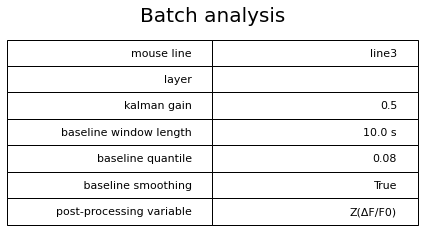

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

## Input data

### Load data

In [6]:
logger.info(f'loading data from {trialavg_dir}:')
data = load_processed_datasets(trialavg_dir, exclude_patterns=['2021'])

 01/06/2022 16:42:54: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/line3:
 01/06/2022 16:42:54: excluding datasets with the following patterns: ['2021']
 01/06/2022 16:42:54: loading timeseries data from timeseries_20191107_mouse1_region1.csv
 01/06/2022 16:42:55: loading timeseries data from timeseries_20191107_mouse1_region2.csv
 01/06/2022 16:42:55: loading timeseries data from timeseries_20191108_mouse6_region1.csv
 01/06/2022 16:42:56: loading timeseries data from timeseries_20191108_mouse6_region2.csv
 01/06/2022 16:42:57: loading timeseries data from timeseries_20191109_mouse7_region1.csv
 01/06/2022 16:42:58: loading timeseries data from timeseries_20191109_mouse7_region2.csv
 01/06/2022 16:42:59: loading timeseries data from timeseries_20191109_mouse7_region3_layer5.csv
 01/06/2022 16:42:59: loading timeseries data from timeseries_20191110_mouse6_region1_layer5.csv
 01/06/2022 16:43:00: 

### Break down data

In [7]:
timeseries, stats = data['timeseries'], data['stats']

### Breakdown per mouse region & exclude datasets with low cell count

 01/06/2022 16:43:29: setting minimum cell count of 252 as inclusion criterion
 01/06/2022 16:43:29: excluding the following datasets from analysis: 
                          cell count
dataset                            
20191107_mouse1_region2         110
20191113_mouse9_region2         233


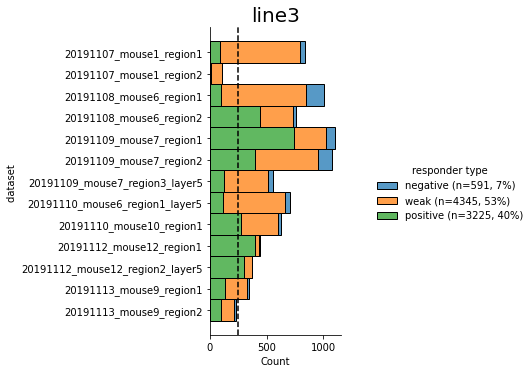

In [8]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = int(np.round(MIN_CELL_DENSITY * area))

# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count,
    title=mouseline)

# Idendify datasets with a low overall cell count
logger.info(f'setting minimum cell count of {min_cell_count} as inclusion criterion')
cells = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = cells.groupby(Label.DATASET).count().iloc[:, 0].rename('cell count')
to_exclude = cellcounts.loc[cellcounts < min_cell_count]

# Exclude them
timeseries, stats = exclude_datasets(timeseries, stats, to_exclude)

## Parameter dependency curves

### Plotting function

In [9]:
def plot_dep_curves(stats, ykey, title=None):
    logger.setLevel(logging.WARNING)
    for pkey in [Label.P, Label.DC]:
        figs[f'{pkey}-dep {ykey}'] = plot_parameter_dependency_across_datasets(
            stats, pkey, Label.ZSCORE)
        if title is not None:
            figs[f'{pkey}-dep {ykey}'].suptitle(title)
    logger.setLevel(logging.INFO)

### With default parameters

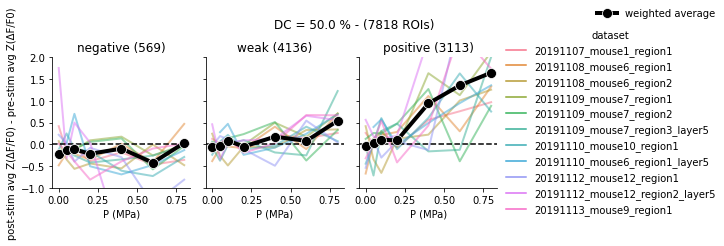

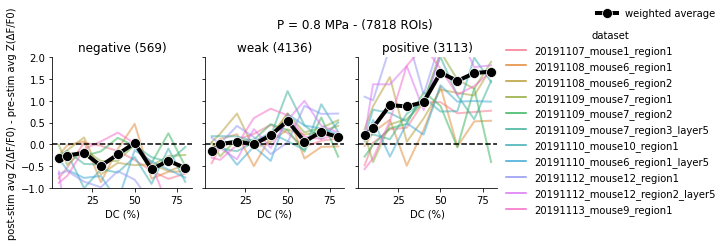

In [10]:
plot_dep_curves(stats, ykey_postpro)

### Influence of threshold number of conditions 

 01/06/2022 16:43:32: re-classifying responders with threshold number of conditions = 3
 01/06/2022 16:43:32: cell breakdown:
  - positive: 5317 (68.0%)
  - weak: 1395 (17.8%)
  - negative: 1106 (14.1%)
 01/06/2022 16:43:33: re-classifying responders with threshold number of conditions = 5
 01/06/2022 16:43:34: cell breakdown:
  - weak: 4136 (52.9%)
  - positive: 3113 (39.8%)
  - negative: 569 (7.3%)
 01/06/2022 16:43:35: re-classifying responders with threshold number of conditions = 7
 01/06/2022 16:43:35: cell breakdown:
  - weak: 6096 (78.0%)
  - positive: 1585 (20.3%)
  - negative: 137 (1.8%)


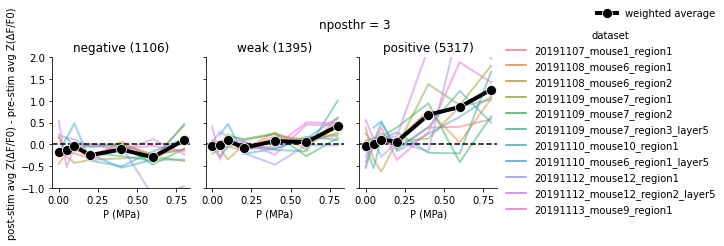

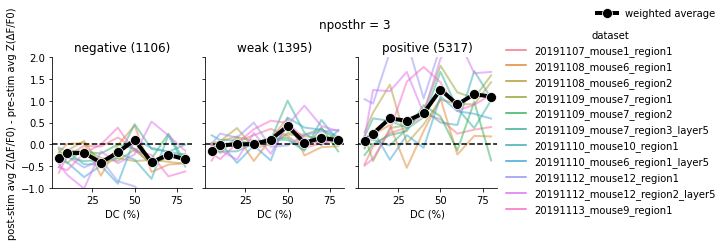

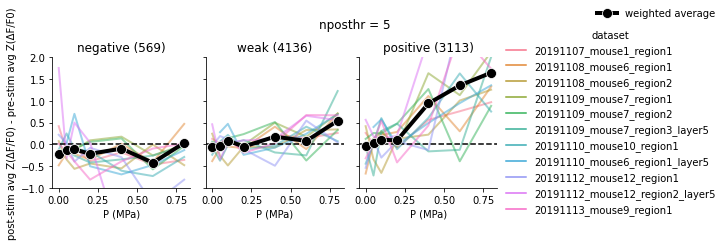

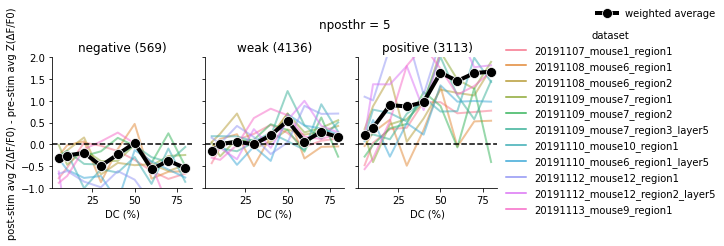

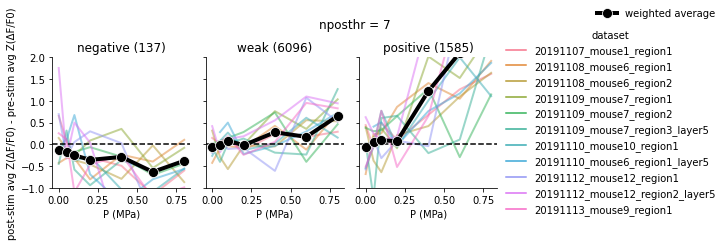

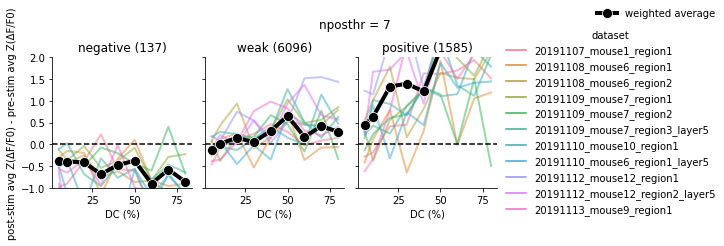

In [11]:
for n in [3, 5, 7]:
    stats2 = classify_responders(stats.copy(), nposthr=n)
    plot_dep_curves(stats2, ykey_postpro, title=f'nposthr = {n}')

### Influence of pre-stimulus detection window

 01/06/2022 16:43:37: adding post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) metrics to stats dataset...
 01/06/2022 16:43:37: applying series_avg function on Z(ΔF/F0) in [9-10] index window across dataset, ROI, run ...
 01/06/2022 16:43:44: applying series_avg function on Z(ΔF/F0) in [10-19] index window across dataset, ROI, run ...
 01/06/2022 16:43:51: testing for significant Z(ΔF/F0) differences between pre- and post-stimulus windows...
 01/06/2022 16:45:10: classifying responses...
 01/06/2022 16:45:10: re-classifying responders with threshold number of conditions = 5
 01/06/2022 16:45:10: cell breakdown:
  - weak: 5470 (70.0%)
  - positive: 2058 (26.3%)
  - negative: 290 (3.7%)
 01/06/2022 16:45:11: adding post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) metrics to stats dataset...
 01/06/2022 16:45:11: applying series_avg function on Z(ΔF/F0) in [7-10] index window across dataset, ROI, run ...
 01/06/2022 16:45:18: applying series_avg function on Z(ΔF/F0) in [10-19] index window ac

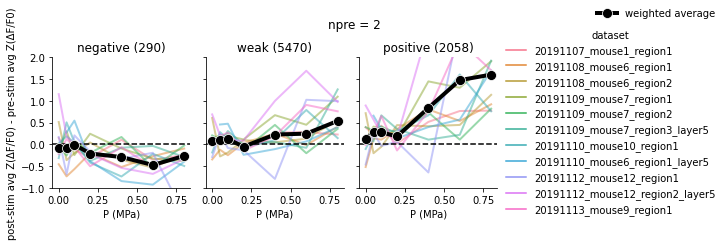

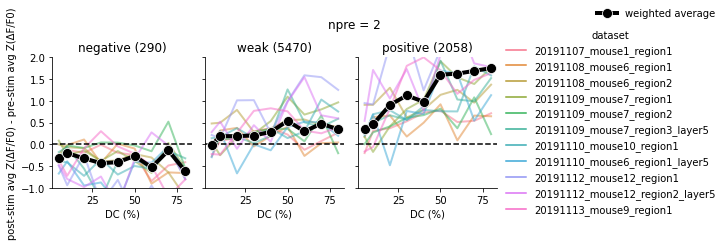

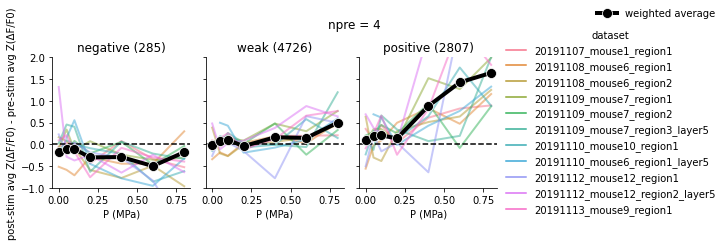

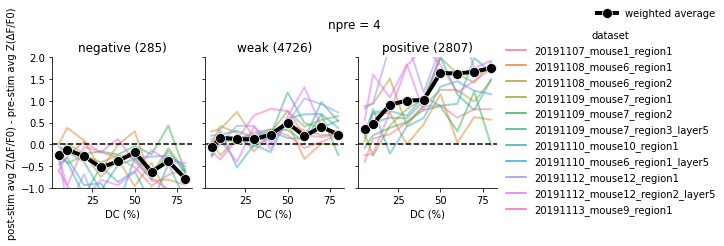

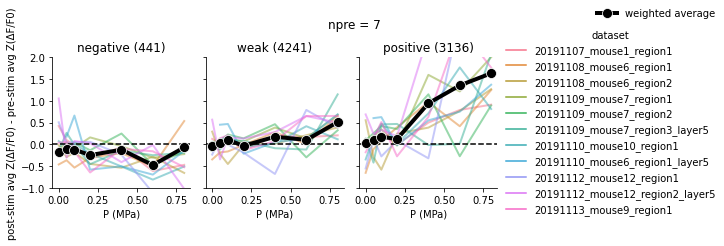

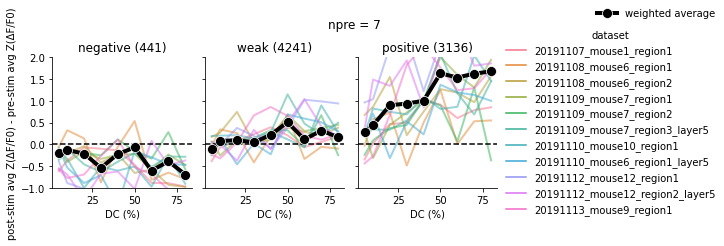

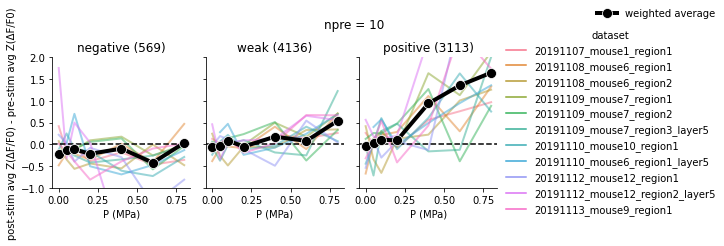

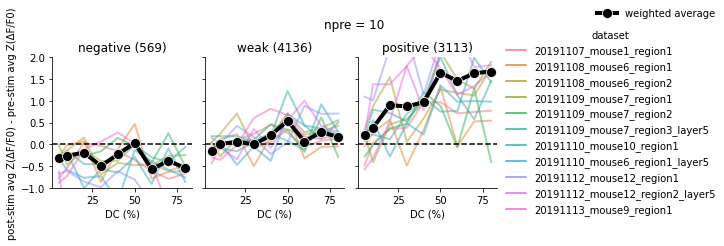

In [12]:
for n in [2, 4, 7, 10]:
    stats2 = classify(
        timeseries, stats.copy(), Label.ZSCORE, 
        wpre=slice(FrameIndex.STIM - n + 1, FrameIndex.STIM + 1))
    plot_dep_curves(stats2, ykey_postpro, title=f'npre = {n}')

### Influence of post-stimulus detection window

 01/06/2022 16:49:58: adding post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) metrics to stats dataset...
 01/06/2022 16:49:58: applying series_avg function on Z(ΔF/F0) in [1-10] index window across dataset, ROI, run ...
 01/06/2022 16:50:05: applying series_avg function on Z(ΔF/F0) in [10-15] index window across dataset, ROI, run ...
 01/06/2022 16:50:12: testing for significant Z(ΔF/F0) differences between pre- and post-stimulus windows...
 01/06/2022 16:51:30: classifying responses...
 01/06/2022 16:51:30: re-classifying responders with threshold number of conditions = 5
 01/06/2022 16:51:30: cell breakdown:
  - weak: 4722 (60.4%)
  - positive: 2613 (33.4%)
  - negative: 483 (6.2%)
 01/06/2022 16:51:31: adding post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) metrics to stats dataset...
 01/06/2022 16:51:31: applying series_avg function on Z(ΔF/F0) in [1-10] index window across dataset, ROI, run ...
 01/06/2022 16:51:38: applying series_avg function on Z(ΔF/F0) in [10-20] index window ac

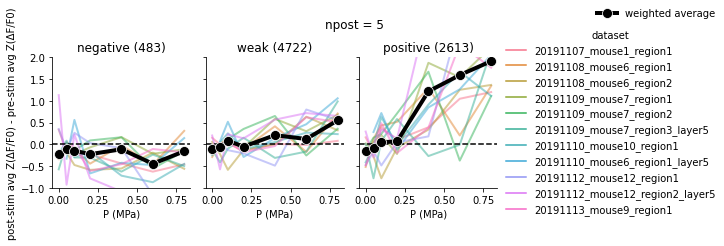

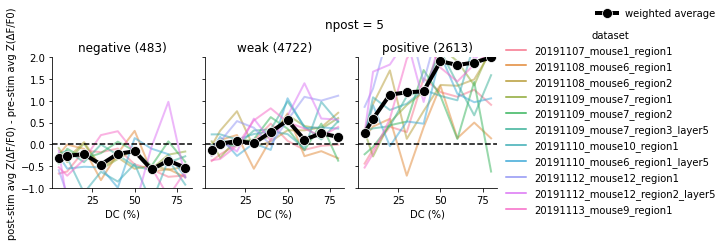

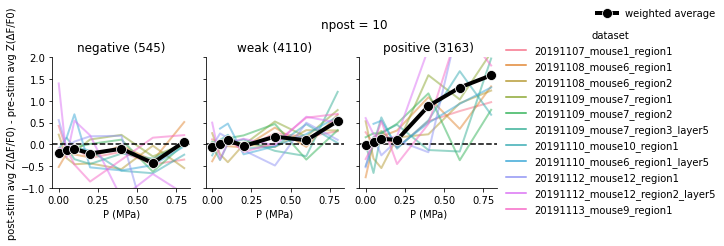

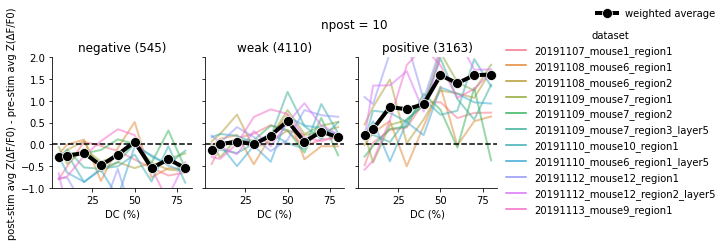

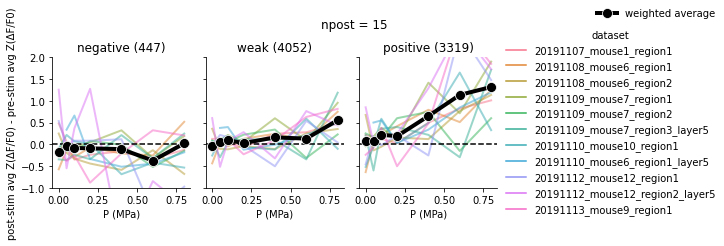

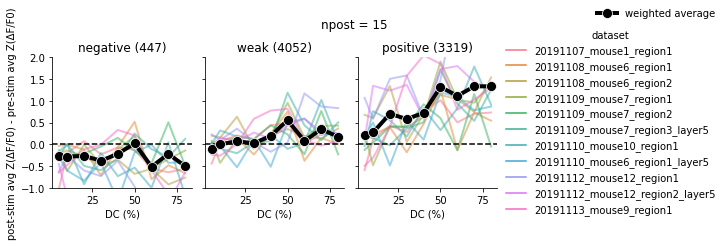

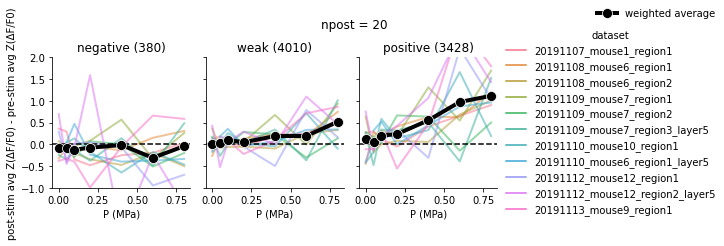

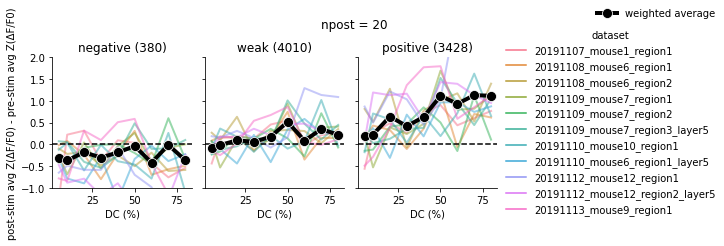

In [13]:
for n in [5, 10, 15, 20]:
    stats2 = classify(
        timeseries, stats.copy(), Label.ZSCORE, 
        wpost=slice(FrameIndex.STIM, FrameIndex.STIM + n + 1))
    plot_dep_curves(stats2, ykey_postpro, title=f'npost = {n}')

## Response traces

### Get plot-ready traces dataset

In [14]:
plt_data = get_plot_data(timeseries, stats)

 01/06/2022 16:56:19: merging timeseries and stats information...
 01/06/2022 16:57:03: adding time info to table...


### Pressure-dependent response traces

 01/06/2022 16:57:15: plotting P (MPa) dependency curves for negative responders...
 01/06/2022 16:57:15: sub-indexing data...
 01/06/2022 16:57:15: filtering data...
 01/06/2022 16:57:15: cross-checking filters...
 01/06/2022 16:57:15: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 01/06/2022 16:57:19: plotting P (MPa) dependency curves for positive responders...
 01/06/2022 16:57:20: sub-indexing data...
 01/06/2022 16:57:20: filtering data...
 01/06/2022 16:57:21: cross-checking filters...
 01/06/2022 16:57:22: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 01/06/2022 16:57:38: plotting P (MPa) dependency curves for weak responders...
 01/06/2022 16:57:40: sub-indexing data...
 01/06/2022 16:57:40: filtering data...
 01/06/2022 16:57:41: cross-checking filters...
 01/06/2022 16:57:42: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


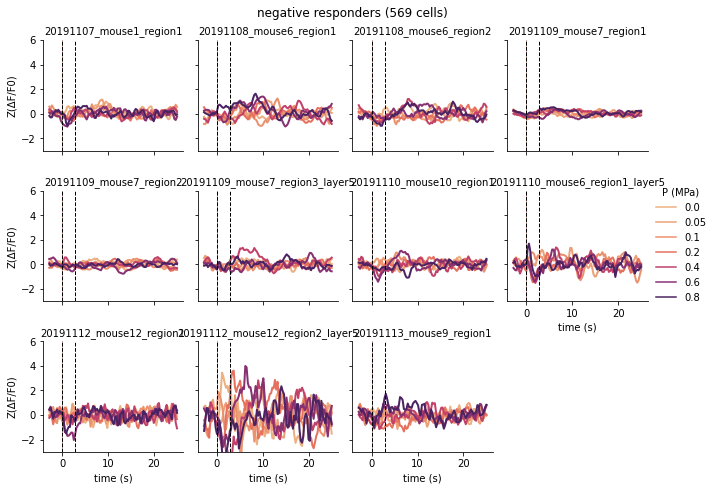

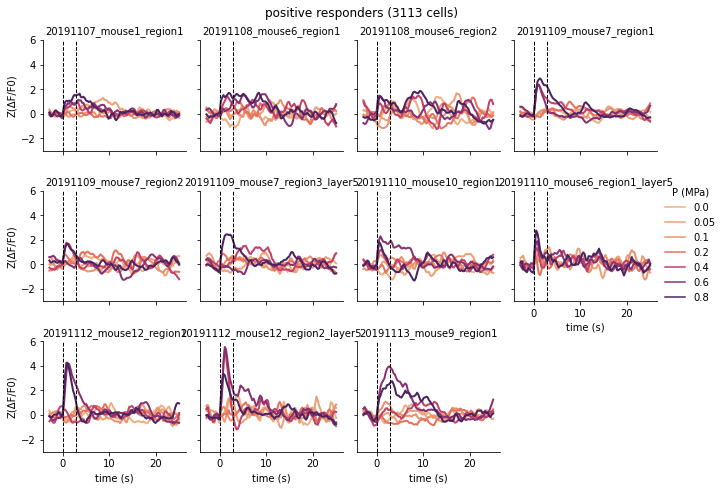

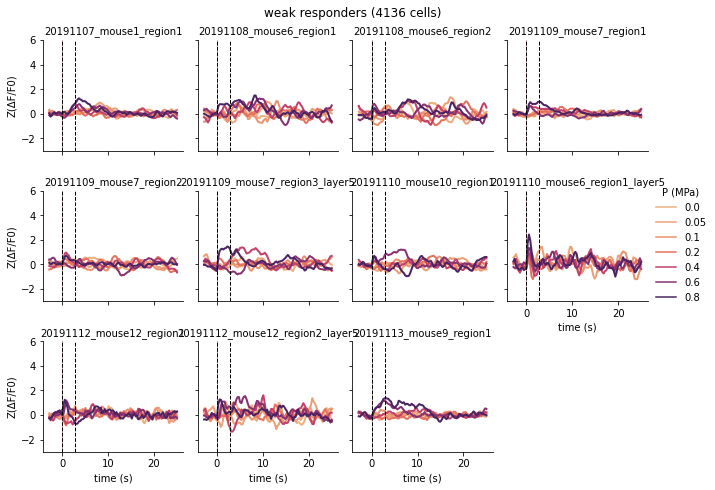

In [15]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 01/06/2022 16:58:07: plotting DC (%) dependency curves for negative responders...
 01/06/2022 16:58:07: sub-indexing data...
 01/06/2022 16:58:07: filtering data...
 01/06/2022 16:58:07: cross-checking filters...
 01/06/2022 16:58:07: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 01/06/2022 16:58:12: plotting DC (%) dependency curves for positive responders...
 01/06/2022 16:58:14: sub-indexing data...
 01/06/2022 16:58:14: filtering data...
 01/06/2022 16:58:15: cross-checking filters...
 01/06/2022 16:58:16: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 01/06/2022 16:58:36: plotting DC (%) dependency curves for weak responders...
 01/06/2022 16:58:38: sub-indexing data...
 01/06/2022 16:58:38: filtering data...
 01/06/2022 16:58:39: cross-checking filters...
 01/06/2022 16:58:41: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


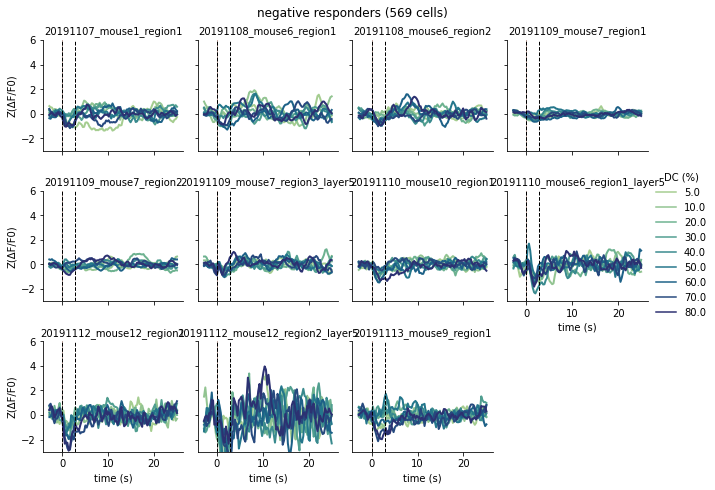

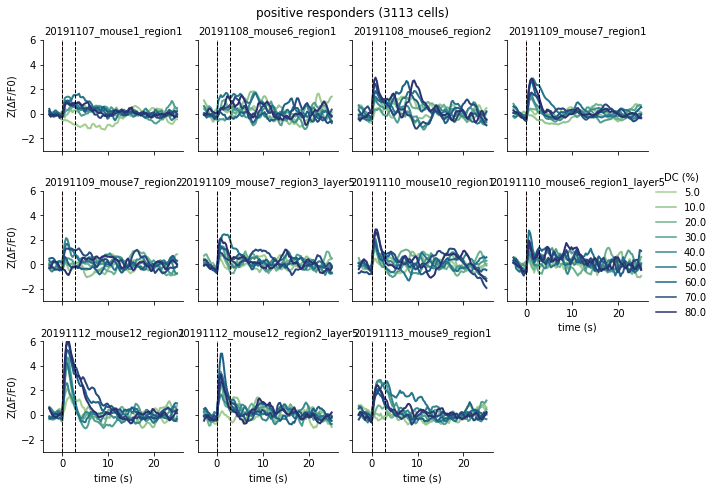

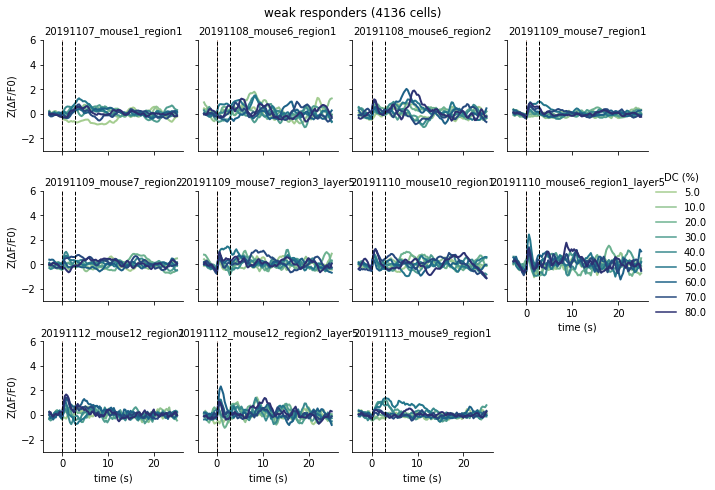

In [16]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 01/06/2022 16:59:07: sub-indexing data...
 01/06/2022 16:59:07: filtering data...
 01/06/2022 16:59:11: cross-checking filters...
 01/06/2022 16:59:13: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 01/06/2022 16:59:40: sub-indexing data...
 01/06/2022 16:59:40: filtering data...
 01/06/2022 16:59:43: cross-checking filters...
 01/06/2022 16:59:48: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


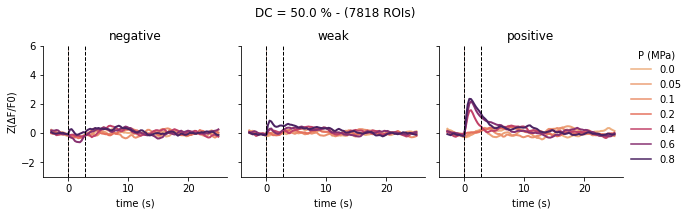

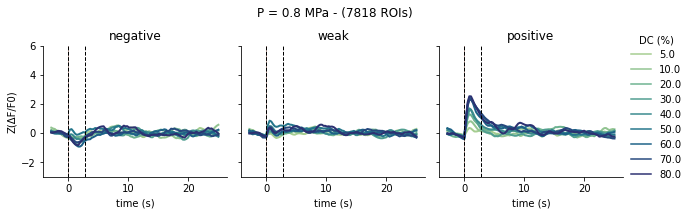

In [17]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 01/06/2022 17:00:25: checking for run order consistency across datasets...
 01/06/2022 17:00:29: computing average traces per dataset and condition...
 01/06/2022 17:00:33: sub-indexing data...
 01/06/2022 17:00:33: filtering data...
 01/06/2022 17:00:33: cross-checking filters...
 01/06/2022 17:00:33: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 01/06/2022 17:00:33: sub-indexing data...
 01/06/2022 17:00:33: filtering data...
 01/06/2022 17:00:33: cross-checking filters...
 01/06/2022 17:00:33: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


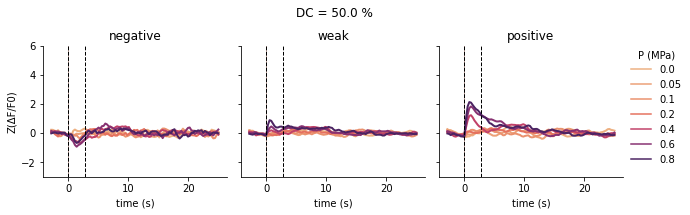

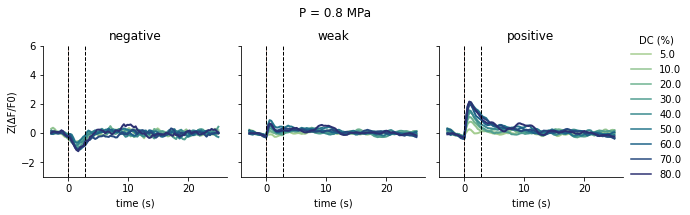

In [18]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [19]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 01/06/2022 17:00:34: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.06.01/figs_line3_k0.5_w10.0s_q0.08_smooth_Z(ΔFF0).pdf:


100%|██████████| 14/14 [00:03<00:00,  4.44it/s]


### Notify upon completion

In [20]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 01/06/2022 17:00:37: line3 batch notebook completed in 0:17:43.656124 s
